In [12]:
import numpy as np
import pandas as pd 
import torch
from torch import optim
import torch.nn as nn
import seaborn as sns
from PIL import Image
from torchvision import models
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler
import os 
import time
import cv2
import random
from skimage import io

# Introduction

The intention of this notebook is to take a look at the dataset and find 

# Look at Images of Dataset

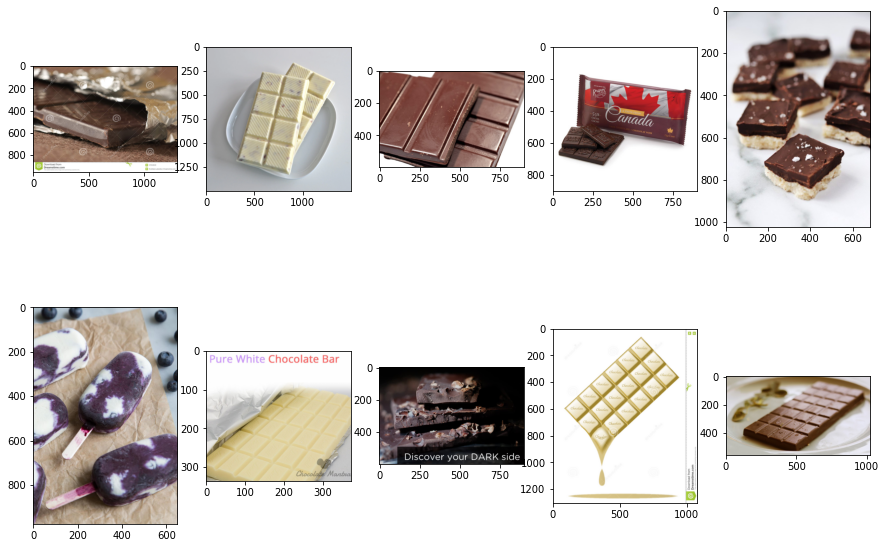

In [5]:
path_of_the_directories = ['/content/Chocolate Classification/Dark Chocolate','/content/Chocolate Classification/White Chocolate']
locs = []
duplicate_detection = []
for path_of_the_directory in path_of_the_directories:
    for file in os.listdir(path_of_the_directory):
        if file.lower().replace(".png","").replace(".jpg","").replace(".jpeg","") not in duplicate_detection:
            locs.append(os.path.join(path_of_the_directory,file))
            duplicate_detection.append(file.lower().replace(".png","").replace(".jpg","").replace(".jpeg",""))
        
fig,ax = plt.subplots(2,5, figsize=(15,10))
for i in range(10):
    j = random.randrange(0, len(locs))
    img = Image.open(locs[j])
    img = img.convert("RGBA").convert("RGB")
    ax[i%2][i//2].imshow(img)

# Examine at Image Shapes

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


Average height 1011.4247787610619


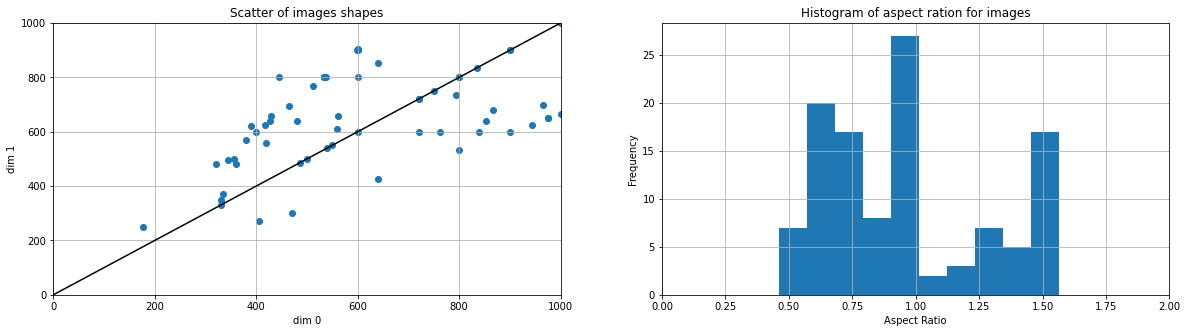

In [6]:
import numpy as np


N = len(locs)
shape = np.zeros((2, N))

for i in range(N): 
    try:
        tmp = np.shape(np.array(io.imread(locs[i], plugin='pil')))
        shape[:, i] = [tmp[0], tmp[1]]
    except:
        print(locs[i], "wouldn't process") 

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].scatter(shape[0, :], shape[1, :])
axs[0].plot(range(0, 1000), range(0, 1000), 'k')
axs[0].set_ylabel('dim 1')
axs[0].set_xlabel('dim 0')
axs[0].grid()
axs[0].set_title('Scatter of images shapes')
axs[0].set_xlim([0, 1000])
axs[0].set_ylim([0, 1000])

axs[1].hist(shape[0, :]/shape[1, :])
axs[1].grid()
axs[1].set_xlabel('Aspect Ratio')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of aspect ration for images')
axs[1].set_xlim([0, 2])

print("Average height " + str(sum(shape[1, :]) / len(shape[1, :])))

# Look at Colors

First we will load up the light and dark chocolates into seperate lists and then find the average dominant color for light chocolate and dark chocolate

In [18]:
path_of_the_dark_chocolate = '/content/Chocolate Classification/Dark Chocolate'
path_of_the_light_chocolate = '/content/Chocolate Classification/White Chocolate'

light_chocolate_locs = []
duplicate_detection = []
for file in os.listdir(path_of_the_light_chocolate):
    if file.lower().replace(".png","").replace(".jpg","").replace(".jpeg","") not in duplicate_detection:
        light_chocolate_locs.append(os.path.join(path_of_the_light_chocolate,file))
        duplicate_detection.append(file.lower().replace(".png","").replace(".jpg","").replace(".jpeg",""))
        
dark_chocolate_locs = []
duplicate_detection = []
for file in os.listdir(path_of_the_dark_chocolate):
    if file.lower().replace(".png","").replace(".jpg","").replace(".jpeg","") not in duplicate_detection:
        dark_chocolate_locs.append(os.path.join(path_of_the_dark_chocolate,file))
        duplicate_detection.append(file.lower().replace(".png","").replace(".jpg","").replace(".jpeg",""))

In [16]:
!pip install ColorThief

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
## top used colors in images 
from colorthief import ColorThief
import urllib 

dominant_light_colors = []
for imgloc in light_chocolate_locs:
    color_thief = ColorThief(imgloc)
    dominant_color = color_thief.get_color(quality=10)
    dominant_light_colors.append(dominant_color)
    
dominant_dark_colors = []
for imgloc in dark_chocolate_locs:
    color_thief = ColorThief(imgloc)
    dominant_color = color_thief.get_color(quality=10)
    dominant_dark_colors.append(dominant_color)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


In [20]:
def add_colors(dominant_colors):
    red = 0
    green = 0
    blue = 0
    for dominant_color in dominant_colors:
        red += dominant_color[0]
        green += dominant_color[1]
        blue += dominant_color[2]
    red = red / len(dominant_colors)
    green = green / len(dominant_colors)
    blue = blue / len(dominant_colors)
    return (int(red), int(green), int(blue))

In [21]:
image_url = "<span style='display:inline-block; min-width:200px; background-color:rgb"+str(add_colors(dominant_light_colors))+";padding:10px 10px;'>"+str(add_colors(dominant_light_colors))+"</span>"
print("Dominant White Chocolate Color")
display(HTML(image_url))
image_url = "<span style='display:inline-block; min-width:200px; background-color:rgb"+str(add_colors(dominant_dark_colors))+";padding:10px 10px;'>"+str(add_colors(dominant_dark_colors))+"</span>"
print("Dominant Dark Chocolate Color")
display(HTML(image_url))

Dominant White Chocolate Color


Dominant Dark Chocolate Color


If we look at the color totals and plot their distributions it gives us an idea of what we are working with. 

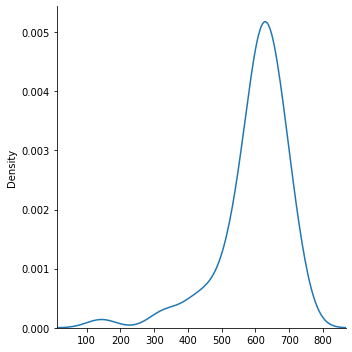

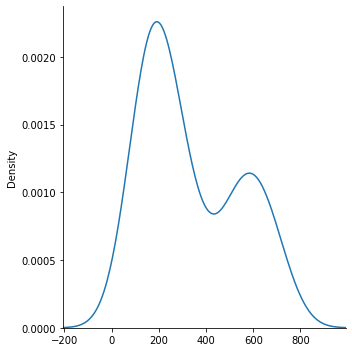

In [22]:
total = []
for dominant in dominant_light_colors:
    total.append(dominant[0] + dominant[1] + dominant[2])
sns.displot(total, kind="kde")
total = []
for dominant in dominant_dark_colors:
    total.append(dominant[0] + dominant[1] + dominant[2])
sns.displot(total, kind="kde")

# Create Predictor

Here I will take the mathematical grey scale value between the light and dominant dark color average. Then I will use that as a simple cutoff to bin the images between white and dark. To see how accurate this simple attempt would be. 

In [23]:
((211 + 202 + 178) - (127 + 107 + 98)) / 2 + (127 + 107 + 98)

461.5

In [24]:
def white_or_black_chocolate(imgloc):
    color_thief = ColorThief(imgloc)
    dominant_color = color_thief.get_color(quality=10)
    if (dominant_color[0] + dominant_color[1] + dominant_color[2]) > 461.5:
        return 1
    else:
        return 0

white_predictions = []
for imgloc in light_chocolate_locs:
    white_predictions.append(white_or_black_chocolate(imgloc))
    
dark_predictions = []
for imgloc in dark_chocolate_locs:
    dark_predictions.append(white_or_black_chocolate(imgloc))

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


In [25]:
print(str(round((sum(white_predictions) / len(white_predictions) + (1 - sum(dark_predictions) / len(dark_predictions))) / 2 * 100 , 2)) +"% Accurate")

79.14% Accurate


# Conclusion

The dataset is quite small and unfortunately suffers a couple of duplicates. Overall it is a fun dataset but one I would caution against drawing definitive conclusions from. 

I had fun with this one and tried a color based predictor which something I had never previously attempted. The accuracy of 78.35% was higher than I expected due to confounding colours from packets and the like in the dataset.